In [1]:
#run patches through vae from scratch

In [2]:
import sys
import os

# Add particle_detection to sys.path
sys.path.append(os.path.abspath(".."))
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

from particle_detection.data.data_pipeline import create_dataloaders
from particle_detection.utils.pca_preprocessing import apply_pca, plot_explained_variance

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is {device}")

Device is cuda


In [5]:
image_dir = "../data"
patch_dir = "../128x128_patches_dataset"
image_size = (128, 128)

train_patches, test_patches = create_dataloaders(data_dir=patch_dir, image_size=(128,128) , batch_size=128)
train_images, test_images = create_dataloaders(data_dir=image_dir, image_size=(2048,2048), batch_size=8)

In [6]:
class VAE(nn.Module):
    def __init__(self, latent_dim=256, input_channels=1):
        super(VAE, self).__init__()
        
        self.latent_dim = latent_dim

        # channels 32 -> 64 -> 128 -> 256 -> 512
        # image size 64 -> 32 -> 16 -> 8 -> 4
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # dynamically compute feature map size
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, 128, 128)
            encoded_output = self.encoder(dummy_input)
            self.flattened_dim = encoded_output.numel()
            self.encoded_shape = encoded_output.shape

        # latent space mapping
        self.fc_mu = nn.Linear(self.flattened_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_dim, latent_dim)

        # channels 256 -> 128 -> 64 -> 32 -> 1
        # image size 8 -> 16 -> 32 -> 64 -> 128
        self.fc_decoder = nn.Linear(latent_dim, self.flattened_dim)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, input_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        # reparameterization trick: z = mu + std * epsilon
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # encode -> reparameterize -> decode
        x = self.encoder(x).view(x.size(0), -1)

        # latent space
        mu = self.fc_mu(x)
        logvar = 10 * torch.tanh(self.fc_logvar(x))
        z = self.reparameterize(mu, logvar)

        # decode
        x = self.fc_decoder(z).view(-1, *self.encoded_shape[1:])  # Reshape back to feature map size
        x = self.decoder(x)
        return x, mu, logvar

    def encode(self, x):
        # get latent space mu
        x = self.encoder(x).view(x.size(0), -1)
        return self.fc_mu(x)


def create_vae(latent_dim=256, input_channels=1):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    vae = VAE(latent_dim=latent_dim, input_channels=input_channels).to(device)
    return vae

In [7]:
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    
    recon_loss = torch.nn.functional.mse_loss(recon_x, x, reduction='sum') / x.size(0)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    total_loss = recon_loss + beta * kl_loss

    return total_loss, recon_loss, kl_loss

In [8]:
def extract_patches(image, patch_size=16, stride=8):
    _, channels, height, width = image.shape

    patches = image.unfold(2, patch_size, stride).unfold(3, patch_size, stride)
    
    patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()
    patches = patches.view(-1, channels, patch_size, patch_size)

    return patches

In [9]:
def extract_latent_representations(data_loader, vae, patch_size=16, device="cuda", batch_size=512):
    vae.eval()
    all_latent_representations = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            batch = batch.to(device)

            for img_idx, img in enumerate(batch):
                img = img.unsqueeze(0)  # add batch dim

                patches = extract_patches(img, patch_size).to(device)

                patches = F.interpolate(patches, size=(128, 128), mode="bilinear", align_corners=False)

                latent_representations = torch.cat([
                    vae.module.encode(patches[i : i + batch_size])
                    for i in range(0, patches.shape[0], batch_size)
                ], dim=0)

                all_latent_representations.append(latent_representations)

    print(f"Processed {len(all_latent_representations)} images.")
    return all_latent_representations

In [10]:
def visualize_clusters(img, cluster_labels, patch_size=16, stride=8):
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()

    height, width = img.shape[1], img.shape[2]
    clustered_image = np.zeros((height, width))

    patch_idx = 0
    weight_matrix = np.zeros((height, width))  # To accumulate values for overlaps

    for i in range(0, height - patch_size + 1, stride):
        for j in range(0, width - patch_size + 1, stride):
            clustered_image[i:i + patch_size, j:j + patch_size] += cluster_labels[patch_idx]
            weight_matrix[i:i + patch_size, j:j + patch_size] += 1
            patch_idx += 1

    # Normalize overlapping regions
    clustered_image /= np.maximum(weight_matrix, 1)

    plt.figure(figsize=(10, 10))
    plt.imshow(clustered_image, cmap="viridis")
    plt.colorbar()
    plt.title("Nanoparticle Clusters with Stride")
    plt.show()

    return clustered_image

In [13]:
def contrastive_loss(z1, z2, y, margin=1.0):
    z1 = F.normalize(z1, p=2, dim=1)
    z2 = F.normalize(z2, p=2, dim=1)

    euclidean_distance = F.pairwise_distance(z1, z2)

    loss = (1 - y) * torch.pow(euclidean_distance, 2) + y * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2)
    
    return loss.mean()

In [15]:
# best results
# latent_dim=128
# beta=5.0
# margin=2.0
# contrastive scalar= 2.0
# eps = 8.0

In [16]:
def train_vae_with_precomputed_contrastive(model, train_loader, optimizer, z1, z2, labels, num_epochs, device="cuda"):
    model.to(device)
    model.train()

    kl_losses = []
    recon_losses = []
    contrastive_losses = []
    total_losses = []

    for epoch in range(num_epochs):
        epoch_kl_loss = 0.0
        epoch_recon_loss = 0.0
        epoch_contrastive_loss = 0.0
        epoch_total_loss = 0.0

        # shuffle contrastive pairs
        perm = torch.randperm(len(z1))
        z1 = z1[perm]
        z2 = z2[perm]
        labels = labels[perm]

        contrastive_i = 0 

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

        for i, batch in enumerate(progress_bar):
            batch = batch.to(device)
            reconstructed, mu, logvar = model(batch)
            total_loss, recon_loss, kl_loss = vae_loss(reconstructed, batch, mu, logvar, beta=5.0)

            if contrastive_i < len(z1):
                z1_batch = z1[contrastive_i].to(device).unsqueeze(0)
                z2_batch = z2[contrastive_i].to(device).unsqueeze(0)
                label = labels[contrastive_i].to(device).unsqueeze(0)

                c_loss = contrastive_loss(z1_batch, z2_batch, label, margin=2.0)
                final_loss = total_loss + (2.0 * c_loss)

                epoch_contrastive_loss += c_loss.item()
                contrastive_i += 1
            else:
                final_loss = total_loss

            final_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_kl_loss += kl_loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_total_loss += final_loss.item()
            
            progress_bar.set_postfix(loss=f"{final_loss.item():.4f}")

        print(f"Recon: {epoch_recon_loss:.2f} | KL: {epoch_kl_loss:.2f} | Contrastive: {epoch_contrastive_loss:.2f}")

        kl_losses.append(epoch_kl_loss / len(train_loader))
        recon_losses.append(epoch_recon_loss / len(train_loader))
        contrastive_losses.append(epoch_contrastive_loss / len(train_loader))
        total_losses.append(epoch_total_loss / len(train_loader))

    return kl_losses, recon_losses, contrastive_losses, total_losses

In [17]:
vae_c_loss = create_vae(latent_dim=128)
vae_c_loss = nn.DataParallel(vae_c_loss).to(device)
optimizer_c_loss = torch.optim.Adam(vae_c_loss.parameters(), lr=1e-3)

In [18]:
z1 = torch.load('../saved_models/z1_tensor.pt')
z2 = torch.load('../saved_models/z2_tensor.pt')
labels = torch.load('../saved_models/labels_tensor.pt')

In [19]:
kl_losses, recon_losses, contrastive_losses, total_losses = train_vae_with_precomputed_contrastive(
    model=vae_c_loss,
    train_loader=train_patches,
    optimizer=optimizer_c_loss,
    z1=z2,
    z2=z1,
    labels=labels,
    num_epochs=10,
    device="cuda"
)

Epoch 1/10: 100%|██████████████████████████████| 187/187 [00:42<00:00,  4.44it/s, loss=3540.2407]


Recon: 110160.37 | KL: 172315.43 | Contrastive: 526.23


Epoch 2/10: 100%|██████████████████████████████| 187/187 [00:38<00:00,  4.80it/s, loss=3875.1003]


Recon: 47962.49 | KL: 109601.90 | Contrastive: 513.86


Epoch 3/10: 100%|██████████████████████████████| 187/187 [00:39<00:00,  4.79it/s, loss=3465.4167]


Recon: 47995.82 | KL: 110922.37 | Contrastive: 507.94


Epoch 4/10: 100%|██████████████████████████████| 187/187 [00:39<00:00,  4.76it/s, loss=3374.5667]


Recon: 41574.00 | KL: 109940.66 | Contrastive: 519.14


Epoch 5/10: 100%|██████████████████████████████| 187/187 [00:39<00:00,  4.79it/s, loss=3153.0061]


Recon: 36030.58 | KL: 108880.95 | Contrastive: 515.70


Epoch 6/10: 100%|██████████████████████████████| 187/187 [00:38<00:00,  4.80it/s, loss=3582.2969]


Recon: 34789.64 | KL: 108786.31 | Contrastive: 512.19


Epoch 7/10: 100%|██████████████████████████████| 187/187 [00:38<00:00,  4.81it/s, loss=3234.0264]


Recon: 33660.72 | KL: 108951.30 | Contrastive: 520.62


Epoch 8/10: 100%|██████████████████████████████| 187/187 [00:39<00:00,  4.78it/s, loss=3214.9163]


Recon: 32202.24 | KL: 108815.58 | Contrastive: 516.23


Epoch 9/10: 100%|██████████████████████████████| 187/187 [00:38<00:00,  4.80it/s, loss=3488.8481]


Recon: 31370.21 | KL: 108765.38 | Contrastive: 521.69


Epoch 10/10: 100%|█████████████████████████████| 187/187 [00:38<00:00,  4.80it/s, loss=3350.7212]

Recon: 34209.15 | KL: 109389.25 | Contrastive: 514.32


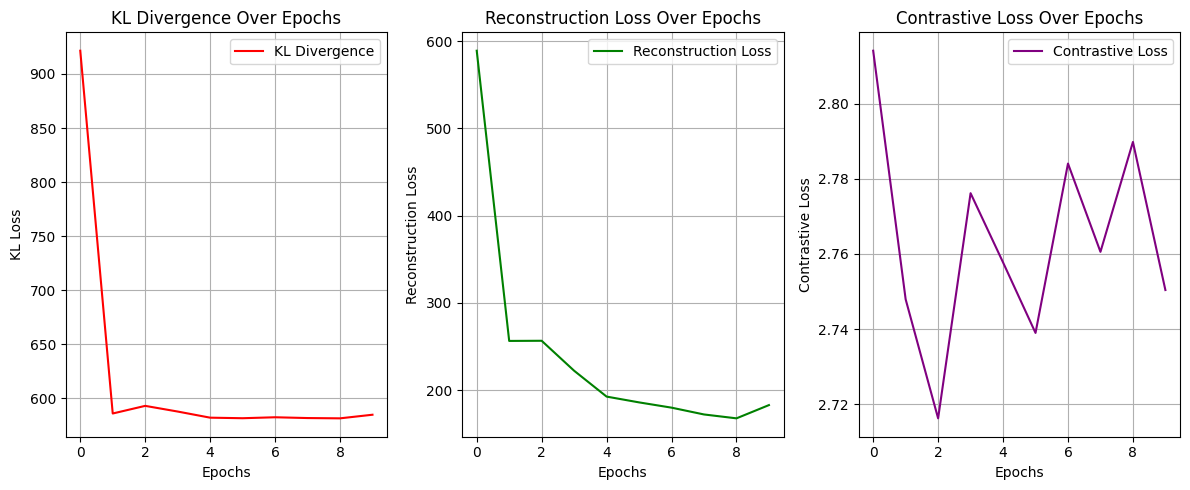

In [20]:
def plot_losses(kl_losses, recon_losses):
    
    loss_data = {
        "KL Divergence": (kl_losses, "KL Loss", "red"),
        "Reconstruction Loss": (recon_losses, "Reconstruction Loss", "green"),
        "Contrastive Loss": (contrastive_losses, "Contrastive Loss", "purple")
    }

    fig, axes = plt.subplots(1, len(loss_data), figsize=(12, 5))  # 1 row, 2 columns

    for ax, (title, (loss_values, ylabel, color)) in zip(axes, loss_data.items()):
        ax.plot(loss_values, label=title, color=color)
        ax.set_xlabel("Epochs")
        ax.set_ylabel(ylabel)
        ax.set_title(f"{title} Over Epochs")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()
    
plot_losses(kl_losses, recon_losses)

In [21]:
def plot_k_distance(data, k=5):
    """
    Plots the k-distance graph to help select the `eps` parameter for DBSCAN.
    
    Args:
        data (np.ndarray): Data for DBSCAN, shape [N, features].
        k (int): The k-th nearest neighbor to calculate distances for.
    
    Returns:
        None (plots the k-distance graph).
    """
    nbrs = NearestNeighbors(n_neighbors=k).fit(data)
    
    distances, _ = nbrs.kneighbors(data)
    
    k_distances = np.sort(distances[:, k-1])
    
    # Plot the sorted k-distances
    plt.figure(figsize=(8, 6))
    plt.plot(k_distances, marker='o')
    plt.title(f"K-Distance Graph (k={k})")
    plt.xlabel("Points (sorted by distance to k-th neighbor)")
    plt.ylabel(f"{k}-Distance")
    plt.grid()
    plt.show()

In [22]:
def cluster_view(cluster_labels, pca):
    plt.figure(figsize=(8, 6))
    plt.scatter(pca[:, 0], pca[:, 1], c=cluster_labels, cmap='tab10', alpha=0.6)
    plt.title('DBSCAN Clustering on PCA Output')
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')
    plt.show()

In [34]:
def normalize_image(image):
    image = (image - image.min()) / (image.max() - image.min()) * 255
    return image.astype(np.uint8)

def label_clusters(sample_img, binary_cluster_labels, patch_size=16, stride=8, cluster_id=None, title="Cluster Contours"):
    img_array = sample_img.cpu().numpy().squeeze()
    img_h, img_w = img_array.shape[:2]
    
    # Normalize the input image
    image_np = normalize_image(img_array)
    
    # Initialize an empty grid for clusters and a weight matrix for normalization
    cluster_grid = np.zeros((img_h, img_w))
    weight_matrix = np.zeros((img_h, img_w))
    
    # Fill the cluster grid using overlapping patches
    patch_idx = 0
    for i in range(0, img_h - patch_size + 1, stride):
        for j in range(0, img_w - patch_size + 1, stride):
            cluster_grid[i:i + patch_size, j:j + patch_size] += binary_cluster_labels[patch_idx]
            weight_matrix[i:i + patch_size, j:j + patch_size] += 1
            patch_idx += 1
    
    # Normalize overlapping regions
    cluster_grid /= np.maximum(weight_matrix, 1)
    
    # Resize to match the original image dimensions
    resized_mask = cv2.resize(cluster_grid, (img_w, img_h), interpolation=cv2.INTER_NEAREST)
    mask = (resized_mask == cluster_id).astype(np.uint8) if cluster_id is not None else (resized_mask > 0).astype(np.uint8)

    # Detect contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Overlay contours on the original image
    overlay = cv2.cvtColor(image_np, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(overlay, contours, -1, (255, 0, 0), 1)

    plt.figure(figsize=(12, 12))
    plt.imshow(overlay, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

In [35]:
def eval_model(model, test_images, device="cuda"):
    model.eval()
    print("in eval mode")

    test_batch = next(iter(test_images))

    # this gets the latent representation for the entire testing dataset
    latent = extract_latent_representations(test_images, model, patch_size=16, device=device)

    for i, img in enumerate(test_batch):
        print(f"Shape before PCA {latent[0].shape}")
        
        latent_space_image = latent[i].cpu().numpy()
        latent_space_normalized = StandardScaler().fit_transform(latent_space_image)
        pca, pca_model = apply_pca(latent_space_normalized, n_components=50)
        
        print(f"Shape after PCA: {pca.shape}")
    
        #plot_k_distance(pca, k=5)
    
        dbscan = DBSCAN(eps=8.0, min_samples=4)
        cluster_labels = dbscan.fit_predict(pca)
    
        #cluster_view(cluster_labels, pca)
    
        #clustered_image = visualize_clusters(test_batch[i].cpu(), cluster_labels, patch_size=16)
    
        label_clusters(test_batch[i], cluster_labels, patch_size=16, cluster_id=-1, title=f"Test image {i}")

in eval mode
Processed 3 images.
Shape before PCA torch.Size([65025, 128])
Shape after PCA: (65025, 27)


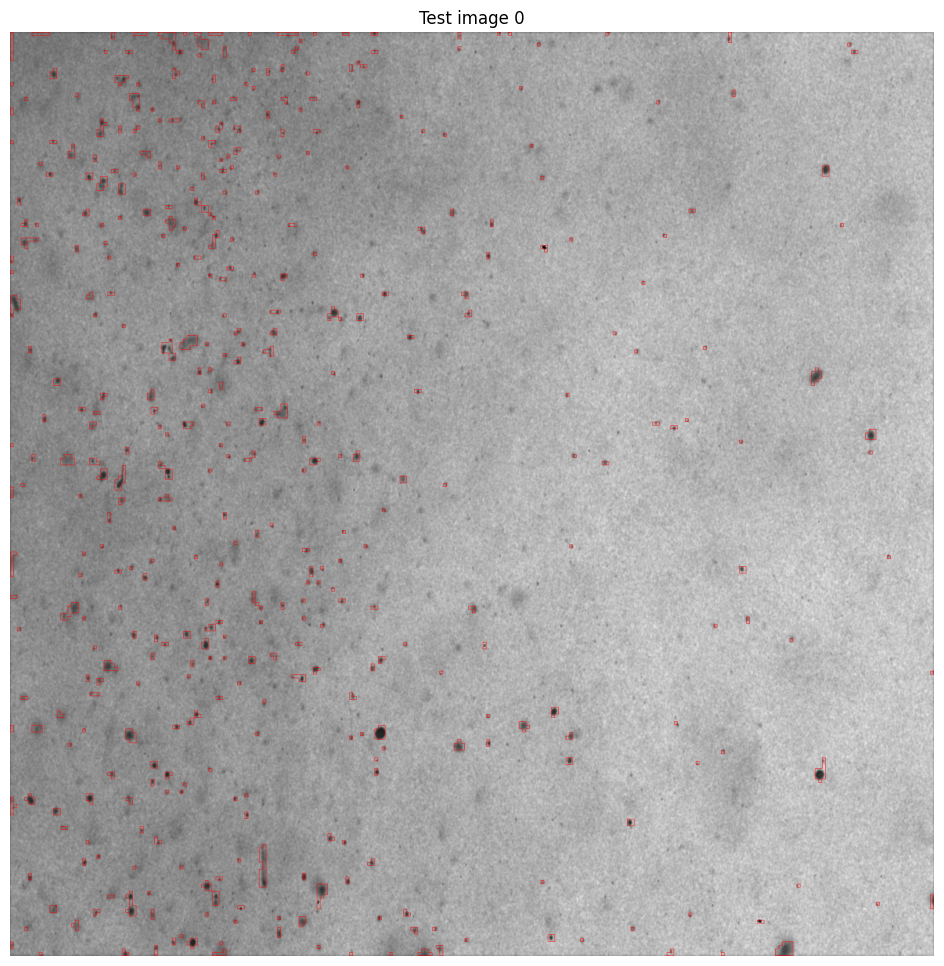

Shape before PCA torch.Size([65025, 128])
Shape after PCA: (65025, 24)


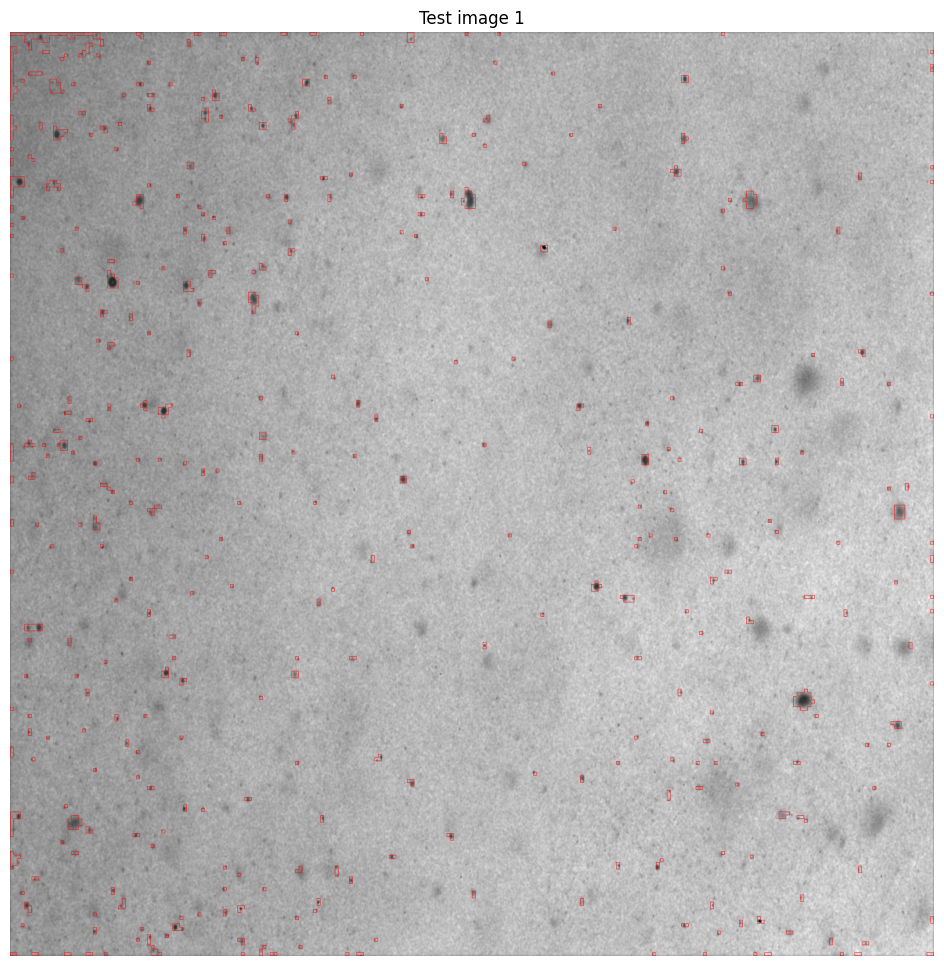

Shape before PCA torch.Size([65025, 128])
Shape after PCA: (65025, 27)


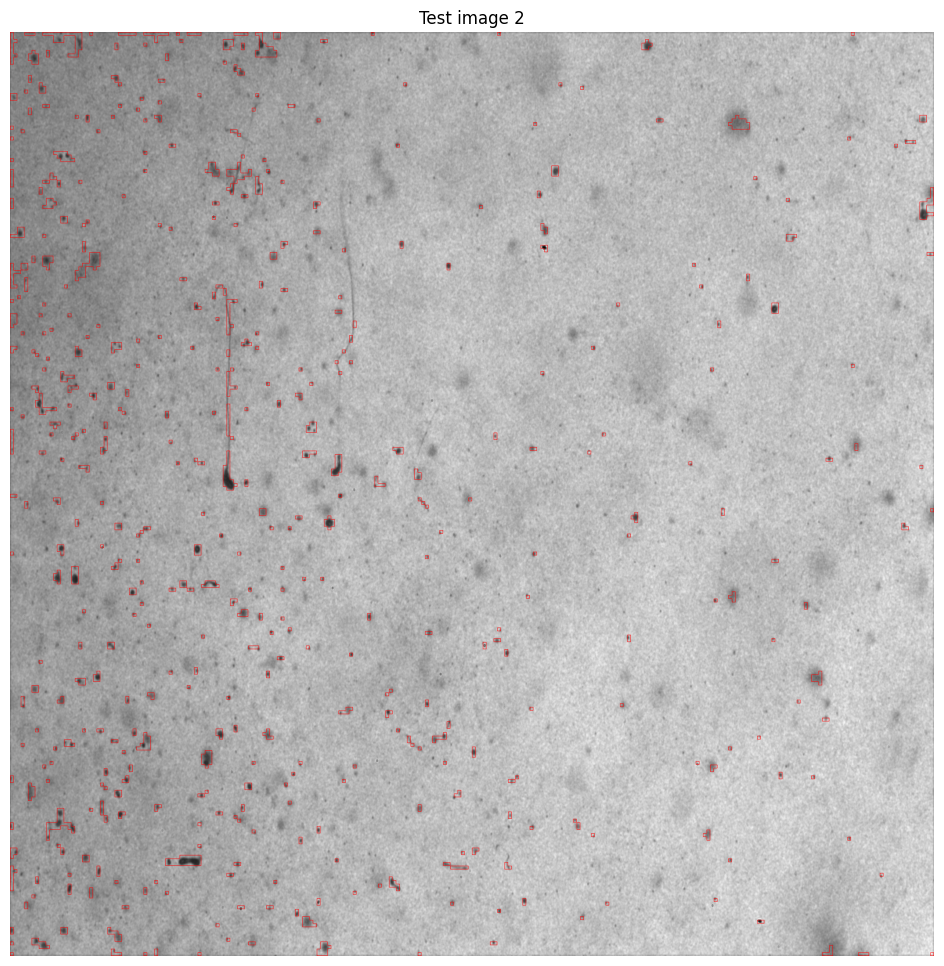

In [36]:
eval_model(vae_c_loss, test_images)